In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as smp
import plotly 
import pandas as pd
import pickle
import edist.ted as ted
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import sys
sys.path.append("../src")

import utils
import ExpressionTree

import re

import tensorflow
from tensorflow import keras

In [2]:
def t1(X):
    return 10*np.exp(-0.5*np.exp(-0.5*X + 2))
X1 = np.linspace(-5, 15, 140)
y1 = t1(X1)

def t2(X):
    return np.exp(-X)
X2 = np.linspace(1, 20, 140)
y2 = t2(X2)

air_passengers = pd.read_csv("data/AirPassengers.csv")
X3 = air_passengers.index
y3 = air_passengers["#Passengers"]

treated_seco = pd.read_csv("data/treated_seco.csv")
treated_seco

treated_seco["eventdate"] = pd.to_datetime(treated_seco["eventdate"])
treated_seco.set_index("eventdate", inplace=True, drop=True)
treated_seco = treated_seco.asfreq("7D")
treated_seco.rename(columns={"Unnamed: 0": "weeks"}, inplace=True)

X4_origin = treated_seco.weeks.values
y4_origin = treated_seco.value.values

X4 = treated_seco.weeks[::2].values
y4 = treated_seco.value[::2].values


# sugar = yf.Ticker("SB=F")
# sugar_history = sugar.history(period="1y")
# sugar_history = sugar_history.asfreq("B")

# # Interpolando os dados
# sugar_history = sugar_history.interpolate()

# sugar_history.reset_index(inplace=True)

sugar_data_manip = pd.read_csv("data/sugar_data_manip.csv")
X5 = sugar_data_manip.X.values
y5 = sugar_data_manip.y.values

data = [
    [X3, y3],
    [X4, y4],
    [X5, y5]
]

In [3]:
def create_df(path):
    with open(path, "rb") as file:
        air_info = pickle.load(file)

    interval = list(air_info.keys())
    funcs = list(air_info.values())

    air_df = pd.DataFrame()
    air_df["interval"] = interval
    air_df["func"] = funcs


    x0 = smp.symbols("x0")
    air_lamb = []

    for i, row in air_df.iterrows():
        lamb = smp.lambdify([x0], row.func)   
        air_lamb.append(lamb)

    air_df["lamb"] = air_lamb

    starts, ends, iters = [], [], []
    pattern = re.compile(r"\d+")
    for row in air_df["interval"]:
        start, end, it = pattern.findall(row)
        
        starts.append(int(start))
        ends.append(int(end))
        iters.append(int(it))

    air_df["start"] = starts
    air_df["end"] = ends
    air_df["iteration"] = iters
    air_df.drop("interval", axis=1, inplace=True)

    sizes = []
    for row in air_df["func"]:
        size = len(utils.exprToTree(row))
        sizes.append(int(size))

    air_df["size"] = sizes

    return air_df

In [4]:
dfs = []
for i in range(0, 2):
    path = rf"E:\Documents\Coding\Repositorios\MyRepositories\Versatus\Janela_Movel\SRRollingMetric\Outputs\Airplane\RollingMetric-120-85-{i}.pkl"
    df = create_df(path)
    dfs.append(df)

In [5]:
air_df = pd.concat(dfs).sort_values("end").reset_index(drop=True)
air_df.head()

,func,lamb,start,end,iteration,size
0,(x0 + 286.20352*exp(sin(0.537315890053563*x0))...,<function _lambdifygenerated at 0x000002BF5634...,120,85,1,19
1,(x0 + (x0 + 18.1020192150762*sin(x0) + 183.273...,<function _lambdifygenerated at 0x000002BF547D...,120,85,0,26
2,(0.3149186*x0 - 20.8247973569416)*exp(exp(-sin...,<function _lambdifygenerated at 0x000002BF561D...,120,85,0,18
3,2.0*x0 + 11.299152*exp(exp(sin(0.5072112*x0)))...,<function _lambdifygenerated at 0x000002BF561D...,120,86,0,14
4,x0 + 62.3682101984737*sin(0.508369593641883*x0...,<function _lambdifygenerated at 0x000002BF561D...,120,86,1,17


# LSTM

<Axes: xlabel='None', ylabel='#Passengers'>

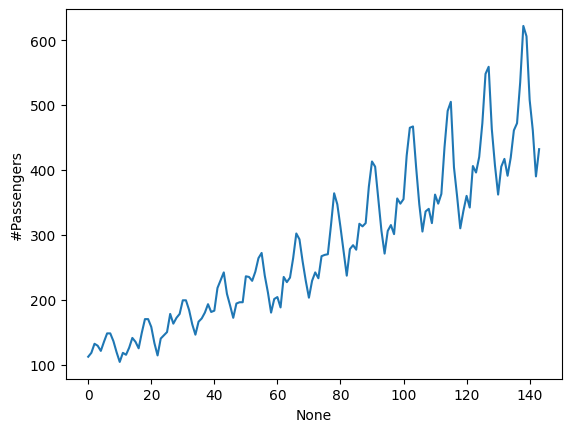

In [131]:
sns.lineplot(x=X3, y=y3)

In [6]:
sc = StandardScaler()
dado_escalado = sc.fit_transform(np.c_[X3, y3])

X3_scaled = dado_escalado[:, 0]
y3_scaled = dado_escalado[:, 1]

<Axes: >

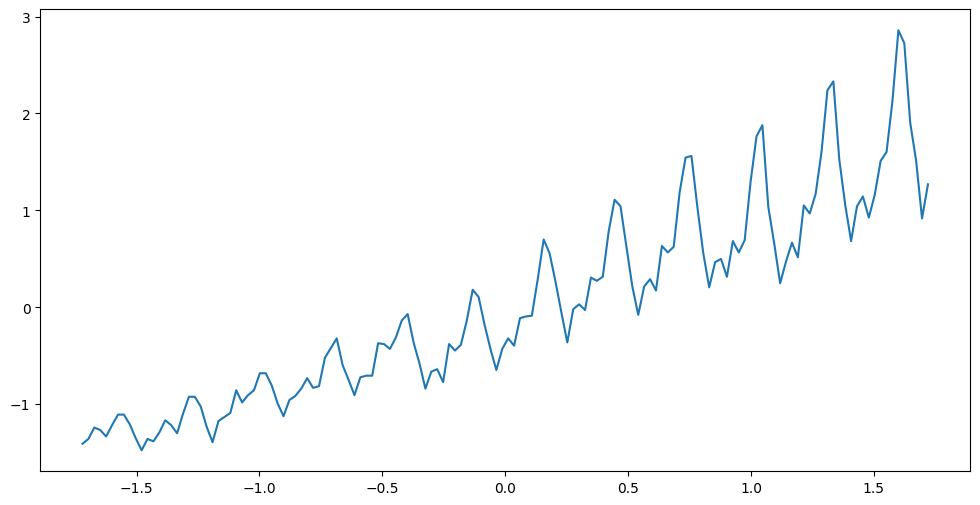

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=X3_scaled, y=y3_scaled)

In [51]:
tamanho_treino = int(len(X3_scaled)*0.74)
tamanho_teste = len(X3_scaled) - tamanho_treino

X_train = X3_scaled[0:tamanho_treino]
y_train = y3_scaled[0:tamanho_treino]

X_test = X3_scaled[tamanho_treino:len(X3_scaled)]
y_test = y3_scaled[tamanho_treino:len(X3_scaled)]

<Axes: >

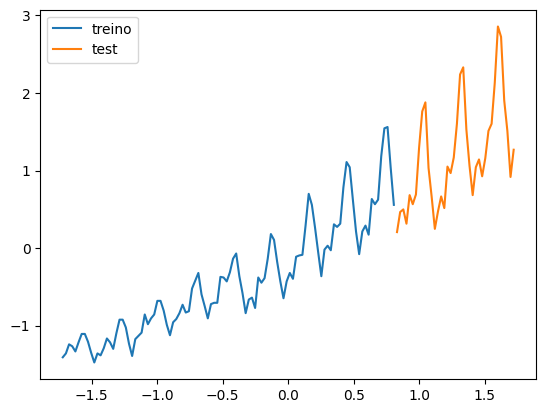

In [52]:
sns.lineplot(x=X_train, y=y_train, label="treino")
sns.lineplot(x=X_test, y=y_test, label="test")

In [116]:
tamanho_teste = int(len(X_test)*0.36)

X_test_one = X_test[0:tamanho_teste]
y_test_one = y_test[0:tamanho_teste]

X_test_two = X_test[tamanho_teste:len(X_test)]
y_test_two = y_test[tamanho_teste:len(X_test)]

<Axes: >

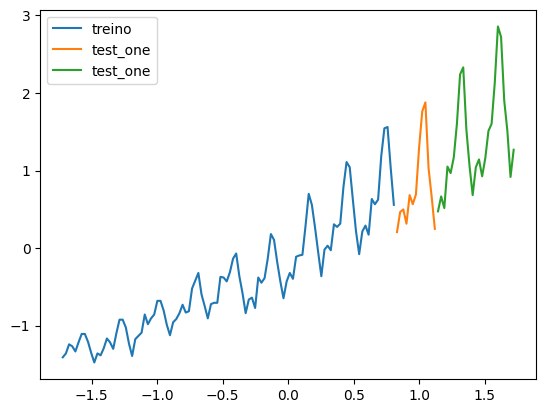

In [117]:
sns.lineplot(x=X_train, y=y_train, label="treino")
sns.lineplot(x=X_test_one, y=y_test_one, label="test_one")
sns.lineplot(x=X_test_two, y=y_test_two, label="test_one")

In [127]:
from keras.models import Sequential
from keras.layers import Dense

def separa_dados(vetor, n_passos):
    X_novo, y_novo = [], []

    for i in range(n_passos, vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])
    
    X_novo, y_novo = np.array(X_novo), np.array(y_novo)
    return X_novo, y_novo

vetor = pd.DataFrame(y_train)[0]
X_treino_novo, y_treino_novo = separa_dados(vetor, 1)

vetor2 = pd.DataFrame(y_test_one)[0]
X_teste_novo, y_test_novo = separa_dados(vetor2, 1)

vetor3 = pd.DataFrame(y_test_two)[0]
X_teste_novo_two, y_teste_novo_two = separa_dados(vetor3, 1)

In [119]:
regressor = Sequential([
    Dense(8, input_dim=1, kernel_initializer="Ones",
          activation="linear", use_bias=True),
    Dense(64, kernel_initializer="random_uniform",
          activation="sigmoid", use_bias=True),
    Dense(1, kernel_initializer="random_uniform",
          activation="linear", use_bias=True)
])

regressor.compile(loss="mean_squared_error", optimizer="adam")

regressor.summary()

e:\Documents\Coding\Repositorios\MyRepositories\Versatus\Janela_Movel\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657 (2.57 KB)

 Trainable params: 657 (2.57 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
regressor.fit(X_treino_novo, y_treino_novo, epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8600
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6842
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5201
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5020
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4615
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4181
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4448
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4500
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3623
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4348
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3929
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4022
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3862 
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3519
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3201
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━

In [121]:
passageiros = pd.DataFrame()
passageiros["tempo"] = X3
passageiros["passageiros"] = y3

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Axes: >

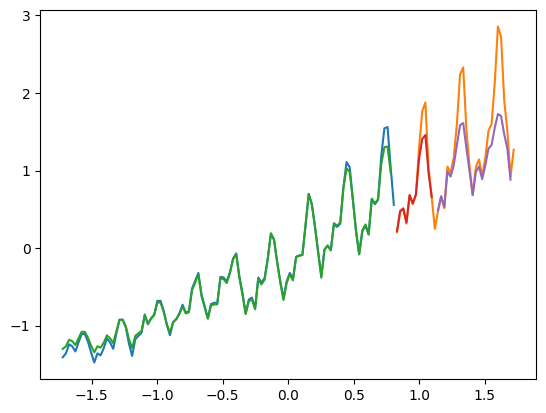

In [129]:
y_predict_novo = regressor.predict(X_treino_novo)
y_predict_test_novo = regressor.predict(X_teste_novo)
y_predict_test_novo_two = regressor.predict(X_teste_novo_two)

sns.lineplot(x=X_train, y=y_train)
sns.lineplot(x=X_test, y=y_test)
sns.lineplot(x=X_train[0:-1], y=y_predict_novo.reshape(-1))
sns.lineplot(x=X_test_one[0:-1], y=y_predict_test_novo.reshape(-1))
sns.lineplot(x=X_test_two[0:-1], y=y_predict_test_novo_two.reshape(-1))